# Calibration of dgemm

Here, we will take as a model:

$T(n) = \alpha + n\times\beta |\mathcal{N}(0, \sigma^2)|$

In [1]:
import pandas
from plotnine import *
import pystan
import matplotlib.pyplot as plt
import numpy
import statsmodels.formula.api as st
import io
import zipfile
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

In [2]:
archive_name = '../hpl/grenoble_2019-01-28_1843947.zip'
experiments = read_csv(archive_name, 'exp.csv')
sizes = list(experiments.matrix_size)
print(sizes)
experiments

[400000, 20000, 100000, 10000, 50000, 200000]


,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,400000,128,16,32,1,2,2,1,0,8,32,1
1,20000,128,16,32,1,2,2,1,0,8,32,1
2,100000,128,16,32,1,2,2,1,0,8,32,1
3,10000,128,16,32,1,2,2,1,0,8,32,1
4,50000,128,16,32,1,2,2,1,0,8,32,1
5,200000,128,16,32,1,2,2,1,0,8,32,1


In [3]:
import sys

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    old_len = len(blas_trace)
    blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    print('\tBLAS trace: %6d lines (removed %d lines with null sizes)' % (len(blas_trace), old_len - len(blas_trace)))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace['kind'] = 'BLAS'
    blas_trace['function'] = blas_trace['function'].str.strip()
    df = blas_trace
    df['rank+1'] = df['rank'] + 1
    df['exp_id'] = exp_id
    return df

traces = None
nbrow_limit = 2000000
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    tmp_trace = read_archive(archive_name, i)
    if len(tmp_trace) > nbrow_limit:
        sys.stderr.write('WARNING: dataframe for exp %d (matrix_size=%d) has %d rows, keeping %d' % (i, size, len(tmp_trace), nbrow_limit))
    tmp_trace = tmp_trace.head(n=nbrow_limit)
    if traces is not None:
        traces = pandas.concat([traces, tmp_trace])
    else:
        traces = tmp_trace

traces.head()

Exp 0 (matrix_size=400000)
	BLAS trace: 296388 lines (removed 12096 lines with null sizes)
Exp 1 (matrix_size=20000)
	BLAS trace: 126825 lines (removed 11963476 lines with null sizes)
Exp 2 (matrix_size=100000)
	BLAS trace: 180879 lines (removed 60202 lines with null sizes)
Exp 3 (matrix_size=10000)
	BLAS trace: 110576 lines (removed 23889596 lines with null sizes)
Exp 4 (matrix_size=50000)
	BLAS trace: 162093 lines (removed 2995582 lines with null sizes)
Exp 5 (matrix_size=200000)
	BLAS trace: 229655 lines (removed 12096 lines with null sizes)


,file,line,function,rank,timestamp,duration,m,n,k,start,end,kind,rank+1,exp_id
0,../HPL_dlocmax.c,125,idamax,0,7.113828,0.000033,25088,NaN,NaN,7.113828,7.113861,BLAS,1,0
1,../HPL_pdmxswp.c,165,dcopy,0,7.113882,0.000007,128,NaN,NaN,7.113882,7.113889,BLAS,1,0
2,../HPL_pdmxswp.c,167,dcopy,0,7.113891,0.000001,128,NaN,NaN,7.113891,7.113892,BLAS,1,0
3,../HPL_pdpancrT.c,214,dscal,0,7.982221,0.000015,25087,NaN,NaN,7.982221,7.982236,BLAS,1,0
4,../HPL_pdpancrT.c,234,dgemv,0,7.982238,0.000140,25087,1.0,NaN,7.982238,7.982378,BLAS,1,0


In [21]:
traces['size'] = traces['m']*traces['n']*traces['k']
df = traces[traces.function == 'dgemm'].copy()
len(df)

150764

In [5]:
def plot_fit(df, alpha, beta, sigma):
    N = len(df)
    noise = numpy.abs(numpy.random.normal(0, sigma, N))
    duration = alpha + df['size'] * (noise + beta)
    tmp = pandas.DataFrame({'size': df['size'], 'duration': duration})
    plot = ggplot(df, aes(x='size', y='duration')) + geom_point() + theme_bw() + geom_point(tmp, color='red', alpha=0.3)
    print(plot)
    print(plot + scale_x_log10() + scale_y_log10())

In [6]:
from math import sqrt, pi

def halfnormal_parameters(data):
    '''
    Suppose that we have a sample of variables Y such that Y=mu+X and X~N(0, sigma).
    This function computes the value of mu and sigma.
    '''
    var = data.var()
    mean = data.mean()
    sigma = sqrt(var / (1-2/pi))
    mu = mean - sigma*sqrt(2)/sqrt(pi)
    return mu, sigma

## Naive approach

In [17]:
def compute_params_naive(df, quantile=0.01):
    small_sizes = df[df['size'] < df['size'].quantile(quantile)]
    large_sizes = df[df['size'] > df['size'].quantile(1-quantile)].copy()
    intercept = small_sizes['duration'].mean()
    large_sizes['size'] -= intercept
    large_sizes['ratio'] = large_sizes['duration'] / large_sizes['size']
    mu, sigma = halfnormal_parameters(large_sizes['ratio'])
    return intercept, mu, sigma

params = compute_params_naive(df)
params

(2.0966988636363636e-06, 6.347686564906995e-11, 4.045663175138883e-12)

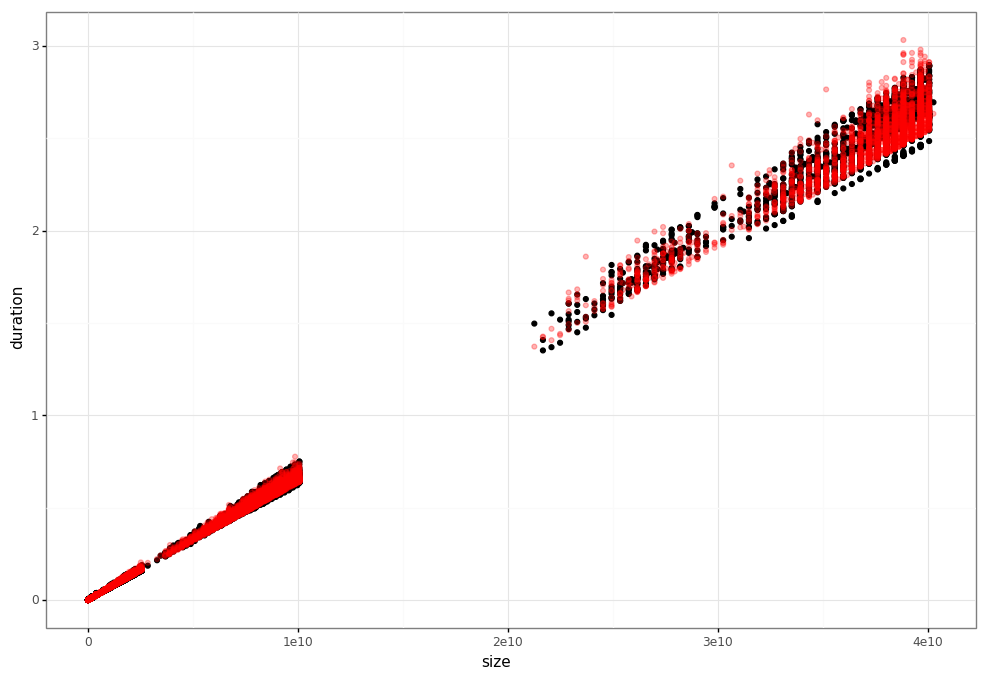

<ggplot: (-9223363310133547327)>


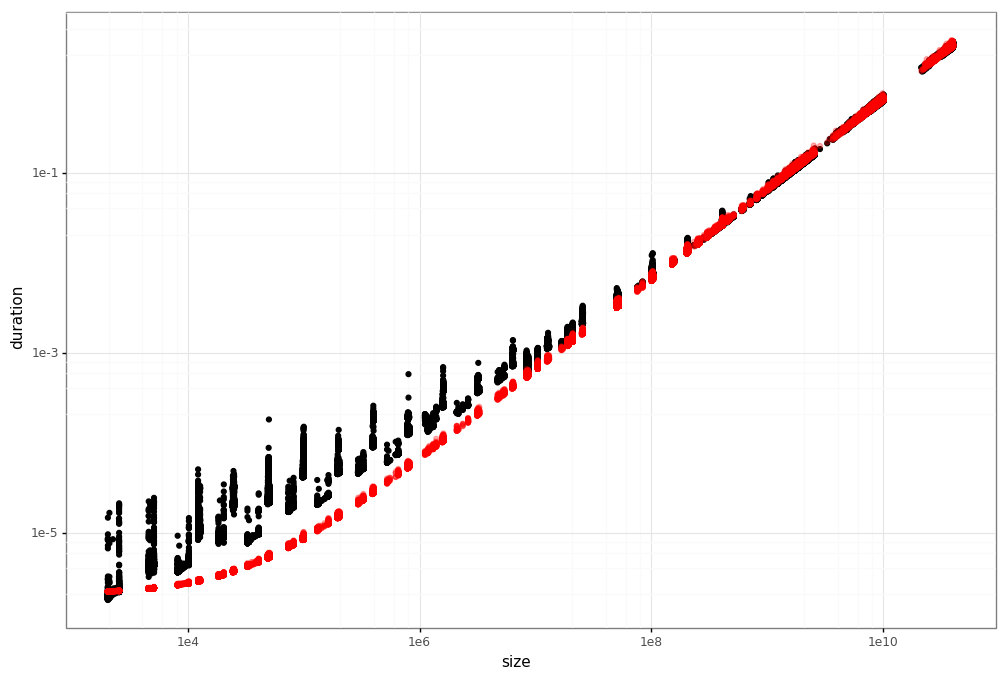

<ggplot: (-9223363310171538130)>


In [8]:
plot_fit(df, *params)

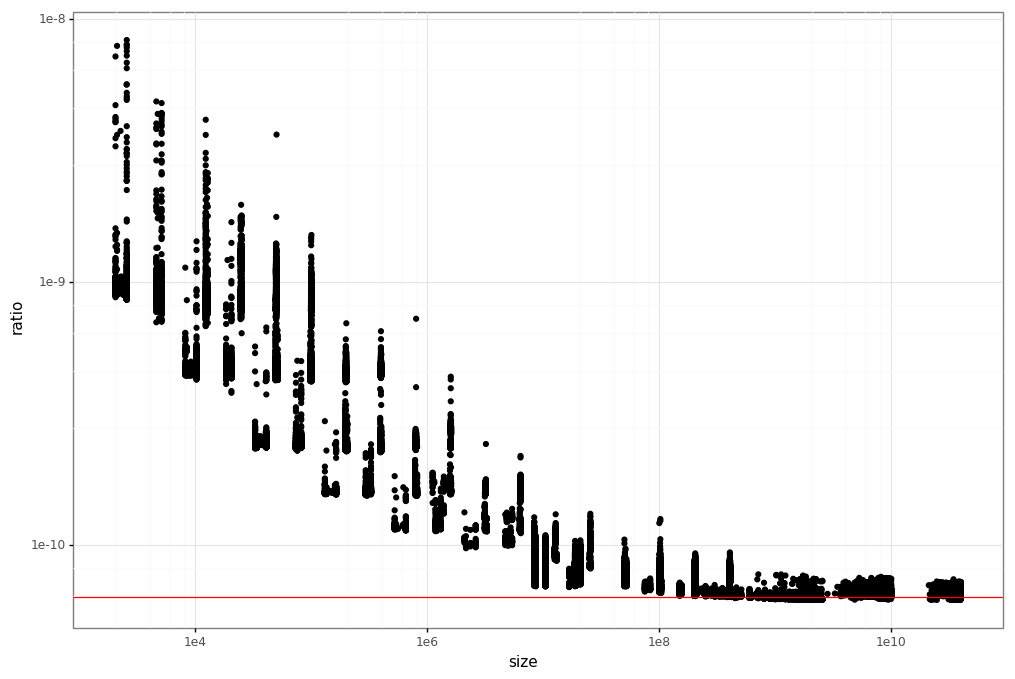

<ggplot: (8726674134108)>

In [25]:
df['ratio'] = df['duration'] / df['size']
ggplot(df, aes(x='size', y='ratio')) + geom_point() + theme_bw() + scale_x_log10() + scale_y_log10() + geom_hline(yintercept=params[1], color='red')

## Linear regression approach

In [9]:
def compute_params_lm(df, quantile=0.01):
    reg = st.ols(data=df, formula='duration ~ size').fit()
    coefficient = reg.params['size']
    intercept = reg.params['Intercept']
    norm_residuals = reg.resid / df['size']
    sigma = norm_residuals.std()
    return intercept, coefficient, sigma

params = compute_params_lm(df)
params

(0.0009015787470266588, 6.670748761509594e-11, 6.019737831304129e-08)

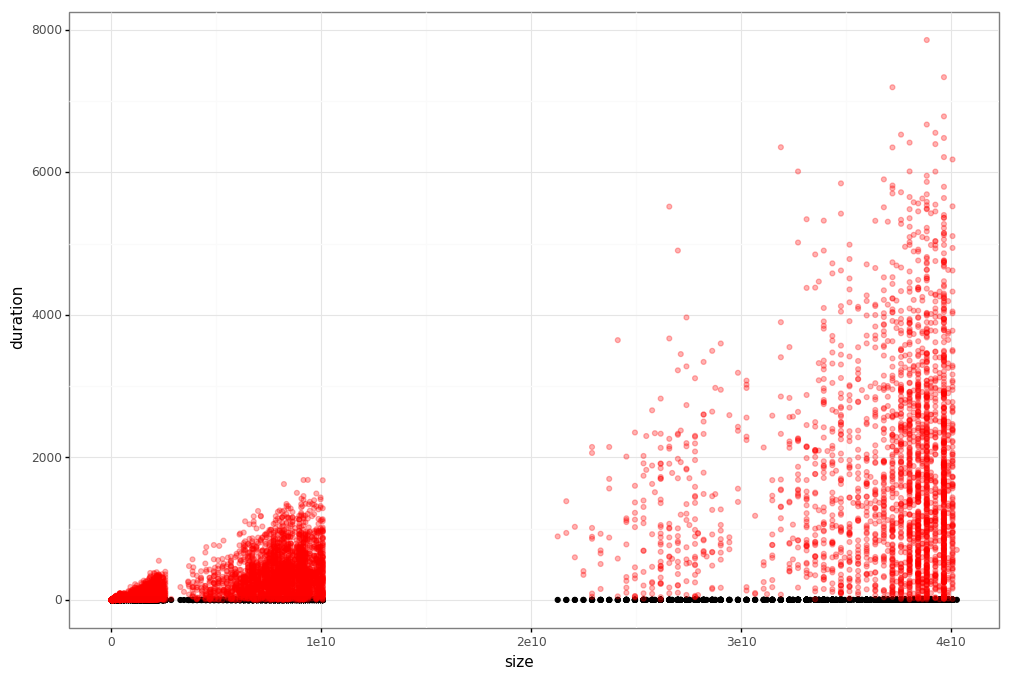

<ggplot: (-9223363310144453586)>


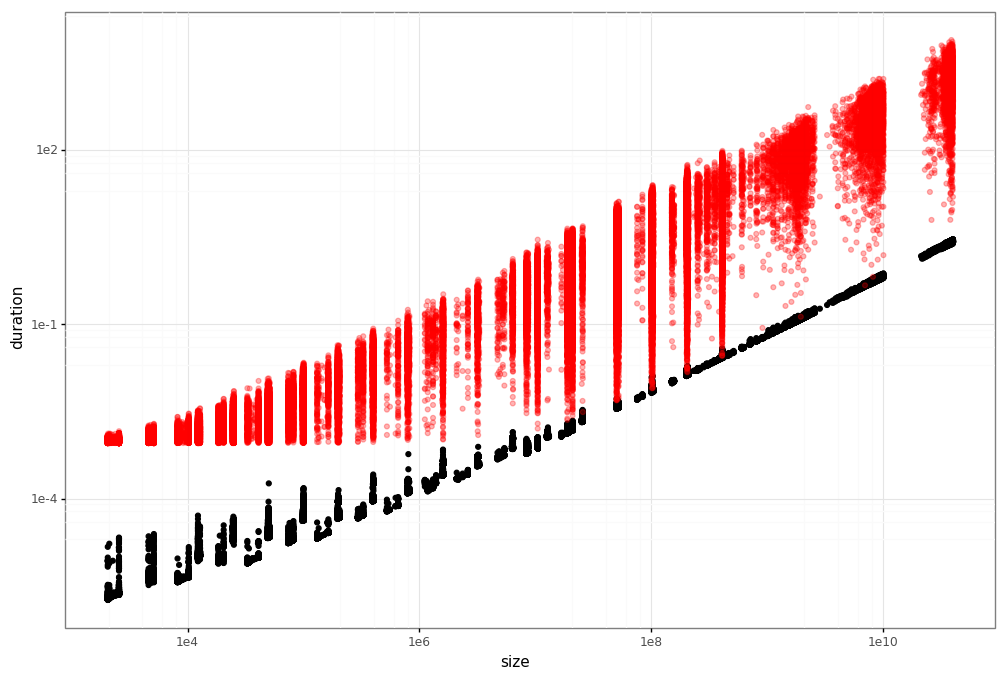

<ggplot: (8726668192383)>


In [10]:
plot_fit(df, *params)

## Bayesian approach

In [11]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector<lower=0>[N] X; // real X[N] does not work
    vector<lower=0>[N] Y;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(0, 20);
    beta ~ normal(0, 20); 
    sigma ~ normal(1, 1);
    Y ~ normal(alpha + X*beta, sigma*X);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5514e8fa74607ab5c64ce19f22cde812 NOW.


CPU times: user 841 ms, sys: 53.1 ms, total: 894 ms
Wall time: 49.6 s


Inference for Stan model: anon_model_5514e8fa74607ab5c64ce19f22cde812.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha 2.7e-6  7.2e-8 1.7e-7 2.7e-6 2.7e-6 2.7e-6 2.7e-6 3.3e-6      5    2.6
beta 1.4e-10 1.9e-114.5e-113.6e-121.6e-101.6e-101.6e-101.6e-10      5   2.63
sigma2.3e-10 5.7e-121.3e-112.2e-102.2e-102.2e-102.2e-102.7e-10      5    2.7
lp__   7.3e5  3393.5 7908.8  7.1e5  7.4e5  7.4e5  7.4e5  7.4e5      5   2.77

Samples were drawn using NUTS at Fri Feb  1 11:32:27 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 547 ms, sys: 237 ms, total: 784 ms
Wall time: 4min 58s


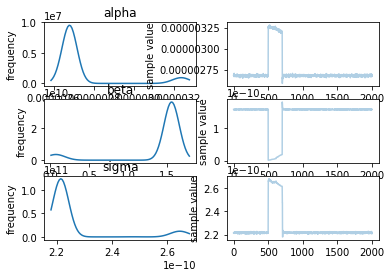

In [12]:
%%time

data=dict(N=len(df), Y=df['duration'], X=df['size'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [13]:
def get_generated_data(fit):
    fit = fit.extract()
    alpha = fit['alpha'].mean()
    beta  = fit['beta'].mean()
    sigma = fit['sigma'].mean()
    return alpha, beta, sigma

params = get_generated_data(fit)
params

(2.7353380851787907e-06, 1.4089352283541638e-10, 2.2592114556627558e-10)

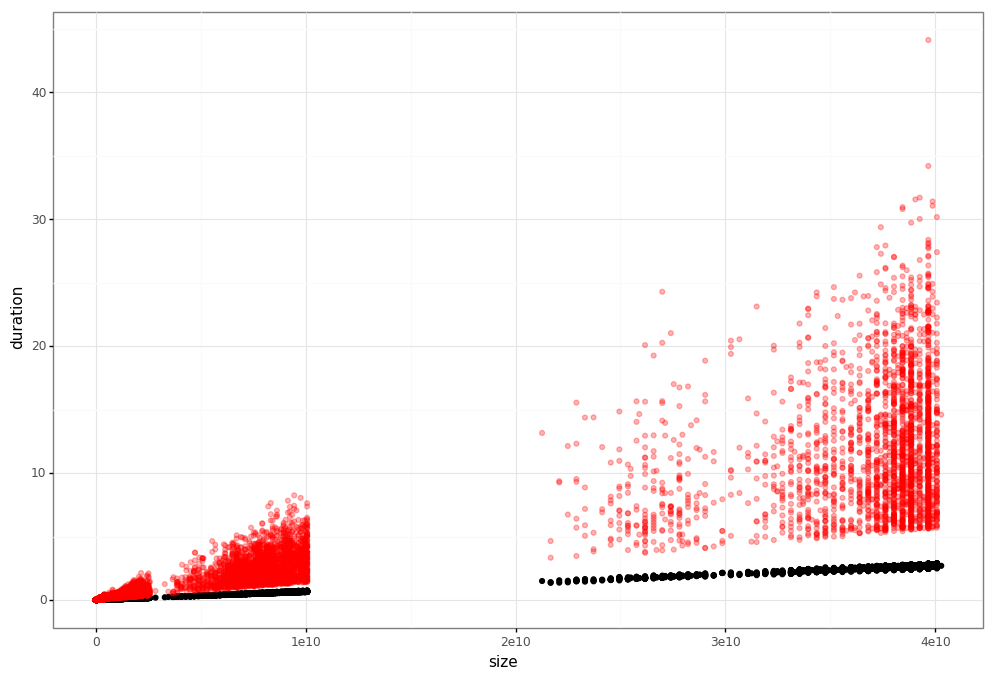

<ggplot: (8726721228527)>


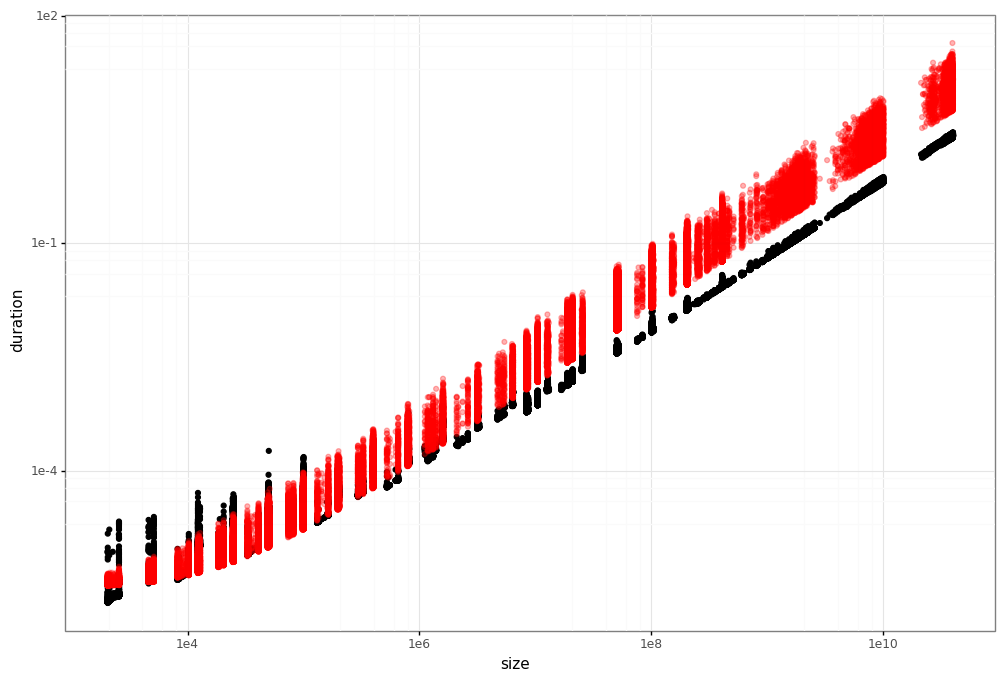

<ggplot: (8726673635213)>


In [14]:
plot_fit(df, *params)

In [26]:
import random

In [174]:
import random

def get_sizes(N, target_product):
    if N == 1:
        return [target_product]
    s = round(random.uniform(1, target_product**(1/N)))
    return [s] + get_sizes(N-1, round(target_product/s))

def get_sizes_limit(N, target_product, max_size):
    while True:
        sizes = get_sizes(N, target_product)
        if all(i <= max_size for i in sizes):
            return sizes

get_sizes_limit(3, 1e10, 16000)

[480, 3649, 5709]

In [179]:
get_sizes_limit(3, 10, 1000)

[2, 1, 5]